In [75]:
import sys
sys.path.append('..')

In [76]:
DATA_PATH = "../data/dinos.txt"

In [178]:
import numpy as np
from src.utils import *
import random
import pprint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dense, Dropout, SimpleRNN, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras import regularizers, optimizers


In [78]:
data = open(DATA_PATH, 'r').read()
data= data.lower()
chars = list(set(data))
#add empty char
chars = [""] + chars

data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 19909 total characters and 28 unique characters in your data.


In [79]:
all_names =  data.split("\n")
all_names[0]

'aachenosaurus'

In [80]:
chars = sorted(chars)
print(chars)

['', '\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [81]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(ix_to_char)

{   0: '',
    1: '\n',
    2: 'a',
    3: 'b',
    4: 'c',
    5: 'd',
    6: 'e',
    7: 'f',
    8: 'g',
    9: 'h',
    10: 'i',
    11: 'j',
    12: 'k',
    13: 'l',
    14: 'm',
    15: 'n',
    16: 'o',
    17: 'p',
    18: 'q',
    19: 'r',
    20: 's',
    21: 't',
    22: 'u',
    23: 'v',
    24: 'w',
    25: 'x',
    26: 'y',
    27: 'z'}


In [82]:
max_time_steps = max( map( lambda x: len(x), data.split("\n") ))
print(f"The max length of a name (max_num_timesteps) is {max_time_steps}")

num_features = vocab_size
print(f"The size of the character vocabulary is {num_features}")

The max length of a name (max_num_timesteps) is 26
The size of the character vocabulary is 28


# 1. Vectorize dataset (on-hot encoding)

In [83]:
test_example = all_names[0]
test_example

'aachenosaurus'

In [84]:
def create_one_hot(one_pos, vector_size):
    x = np.zeros( vector_size )
    x[one_pos] = 1
    return x

In [85]:
create_one_hot(1, 5)

array([0., 1., 0., 0., 0.])

In [86]:
def vectorize_example(example):
    """
    example: str name
    """
    x = np.zeros((max_time_steps, num_features))
    
    diff_x = max_time_steps - len(example)
    
    for i, c in enumerate(example):
        x[i+diff_x, char_to_ix[c] ] = 1    
    for i in range(diff_x):
        x[i, char_to_ix['']] = 1       
        
    y = np.vstack( (x[1:], create_one_hot(char_to_ix['\n'], num_features)))
    
    return x, y


In [87]:
x, y = vectorize_example(test_example)

In [88]:
print(x.shape, y.shape)

(26, 28) (26, 28)


In [89]:
def devectorize_example(example): 
    result = [ix_to_char[np.argmax(vec)] for vec in example]
    return ''.join(result)

devectorize_example(x)

'aachenosaurus'

In [90]:
devectorize_example(y)

'aachenosaurus\n'

# 2. Create vectorized dataset

In [91]:
def create_vectorized_dataset(data):
    """
    data must be a list of name strings.
    """
    num_examples = len(data)
    
    X = np.zeros((num_examples, max_time_steps, num_features))
    Y = np.zeros((num_examples, max_time_steps, num_features))
    
    for i, example in enumerate(data):
        x_i, y_i = vectorize_example(example)
        X[i] = x_i
        Y[i] = y_i
        
    return X , Y

X,Y = create_vectorized_dataset(all_names)

In [93]:
print(X.shape, Y.shape)

(1536, 26, 28) (1536, 26, 28)


# 3. Create the model

In [258]:
# def get_new_model(hidden_units = 128,
#                   max_time_steps = max_time_steps,
#                   num_features = num_features
#                  ):
    
#     model = Sequential([
#         SimpleRNN(hidden_units, input_shape = (None, num_features),
#                  kernel_regularizer = regularizers.l2(1e-4)),
#         RepeatVector(max_time_steps),
#         SimpleRNN(hidden_units, return_sequences = True,
#                  kernel_regularizer = regularizers.l2(1e-4)),
#         TimeDistributed(Dense(num_features, activation = 'softmax'))
#     ])

#     model.compile(
#         loss = 'categorical_crossentropy',
#         optimizer = optimizers.Adam(learning_rate=0.001
#                                    , clipvalue=0.1),
#         metrics = ['accuracy']
#     )
    
#     return model

def get_new_model(hidden_units = 128,
                  max_time_steps = max_time_steps,
                  num_features = num_features
                 ):
    
    model = Sequential([
        SimpleRNN(hidden_units, input_shape = (None, num_features),
                 kernel_regularizer = regularizers.l2(1e-4), return_sequences = True),
        TimeDistributed(Dense(num_features, activation = 'softmax'))
    ])

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizers.Adam(learning_rate=0.001
                                   , clipvalue=0.1),
        metrics = ['accuracy']
    )
    
    return model
        

In [259]:
model = get_new_model()

In [260]:
# l_cb = LambdaCallback(
#     on_epoch_end = lambda e, l: print('{:.2f}'.format( l["val_acc"]), end = '\n')
# )

es_cb = EarlyStopping(monitor = 'val_accuracy', patience = 30)

history = model.fit(X, Y, epochs = 500, batch_size = 32, validation_split = 0.2,
         verbose = True, callbacks = [es_cb])
         #)

Epoch 1/500
39/39 [==============================] - 0s 6ms/step - loss: 1.8494 - accuracy: 0.5723 - val_loss: 1.4989 - val_accuracy: 0.6395
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 1.4011 - accuracy: 0.6551 - val_loss: 1.3638 - val_accuracy: 0.6692
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 1.2758 - accuracy: 0.6802 - val_loss: 1.2867 - val_accuracy: 0.6832
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 1.1896 - accuracy: 0.6948 - val_loss: 1.2224 - val_accuracy: 0.6948
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 1.1308 - accuracy: 0.7041 - val_loss: 1.1819 - val_accuracy: 0.7052
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 1.0862 - accuracy: 0.7144 - val_loss: 1.1451 - val_accuracy: 0.7139
Epoch 7/500
39/39 [==============================] - 0s 4ms/step - loss: 1.0519 - accuracy: 0.7223 - val_loss: 1.1187 - val_accuracy: 0.7222
Epoch 8/500
3

Epoch 59/500
39/39 [==============================] - 0s 4ms/step - loss: 0.7625 - accuracy: 0.7943 - val_loss: 0.9934 - val_accuracy: 0.7651
Epoch 60/500
39/39 [==============================] - 0s 4ms/step - loss: 0.7604 - accuracy: 0.7928 - val_loss: 1.0019 - val_accuracy: 0.7629
Epoch 61/500
39/39 [==============================] - 0s 4ms/step - loss: 0.7598 - accuracy: 0.7954 - val_loss: 1.0050 - val_accuracy: 0.7604
Epoch 62/500
39/39 [==============================] - 0s 4ms/step - loss: 0.7576 - accuracy: 0.7949 - val_loss: 1.0010 - val_accuracy: 0.7622
Epoch 63/500
39/39 [==============================] - 0s 4ms/step - loss: 0.7554 - accuracy: 0.7961 - val_loss: 0.9996 - val_accuracy: 0.7627
Epoch 64/500
39/39 [==============================] - 0s 4ms/step - loss: 0.7533 - accuracy: 0.7975 - val_loss: 1.0098 - val_accuracy: 0.7622
Epoch 65/500
39/39 [==============================] - 0s 4ms/step - loss: 0.7518 - accuracy: 0.7980 - val_loss: 1.0089 - val_accuracy: 0.7631
Epoch 

In [261]:
ix = 1
x_0 = np.zeros((1, max_time_steps, num_features))
x_0[:, : ,ix] = 1

In [262]:
pred = model.predict( x_0)

In [257]:
devectorize_example(pred[0,:,:])

'aoooaaahaiinaosairua\n\n'

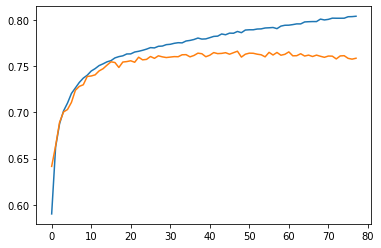

In [254]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

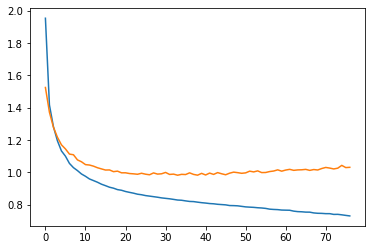

In [247]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])